# **Introduction**

In this notebook, a specific instance of the VRP is modeled; the following problems can be experimented with: 'all', 'single_feat', 'single_feat_otw', 'cvrp', 'ovrp', 'vrpb', 'vrpl', 'vrptw', 'ovrptw', 'ovrpb', 'ovrpl', 'vrpbl', 'vrpbtw', 'vrpltw', 'ovrpbl', 'ovrpbtw', 'ovrpltw', 'vrpbltw', 'ovrpbltw'

- O - open routes
- B - backhauls
- L - limits (duration)
- TW - time windows

Notes:
- args for the generator:
        num_loc: Number of locations to generate
        min_loc: Minimum location value
        max_loc: Maximum location value
        loc_distribution: Distribution to sample locations from
        capacity: Vehicle capacity. If None, get value based on `get_vehicle_capacity`
        min_demand: Minimum demand value
        max_demand: Maximum demand value
        min_backhaul: Minimum backhaul value
        max_backhaul: Maximum backhaul value
        scale_demand: Scale demand values (by default, generate between 1 and 10)
        max_time: Maximum time window value (at depot)
        backhaul_ratio: Fraction of backhauls (e.g. 0.2 means 20% of nodes are backhaul)
        distance_limit: Distance limit
        speed: Speed of vehicle. Defaults to 1
        subsample: If False, we always sample all attributes (i.e., OVRPBLTW)
            If true, we use the
        **kwargs: Additional keyword arguments

In [ ]:
numero_experiencia = "20_final"

In [ ]:
config = dict(gen_num_loc=144,
              gen_capacity=300,
              gen_min_demand=1,
              gen_max_demand=15,
              gen_min_backhaul=1,
              gen_max_backhaul=15,
              gen_backhaul_ratio=0.5,
              gen_variant_preset="ovrpb",
              model='MVMoE_POMO',
              model_batch_size=8,
              model_train_data_size=10000,
              model_val_batch_size=100,
              model_val_data_size=1000,
              model_optimizer="RMSprop", # Adam or RMSprop
              model_optimizer_kwargs={"lr": 1e-4, "weight_decay": 1e-6},
              model_lr_scheduler="MultiStepLR",
              model_lr_scheduler_kwargs={"milestones": [451, ], "gamma": 0.1},
              trainer_max_epochs=10,
              trainer_accelerator="gpu",
              )
config['experience']=f"exp{numero_experiencia}_{config['gen_variant_preset']}_{config['gen_num_loc']}pts_{config['model']}_{config['model_batch_size']}BS_{config['trainer_max_epochs']}epocas"


exp20_final_ovrpb_144pts_MVMoE_POMO_8BS_10epocas


# **CONFIG AND INSTALL**

In [ ]:
%%capture
!pip install -U git+https://github.com/ai4co/rl4co.git
!pip install wandb --upgrade
!pip install pandas
!pip install numpy

In [ ]:
%%capture
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np

from rl4co.envs.routing.mtvrp.env import MTVRPEnv
from rl4co.envs.routing.mtvrp.generator import MTVRPGenerator

from rl4co.envs.routing.cvrp.env import CVRPEnv
from rl4co.envs.routing.cvrp.generator import CVRPGenerator

from rl4co.envs.routing.mdcpdp.env import MDCPDPEnv
from rl4co.envs.routing.mdcpdp.generator import MDCPDPGenerator

from rl4co.utils.trainer import RL4COTrainer
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.models.zoo import MVMoE_POMO
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.ops import gather_by_index

import torch
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from einops import repeat

from google.colab import drive

import wandb
from lightning.pytorch.loggers import WandbLogger


## Mount

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


## Logs e Callbacks

In [ ]:
name = config['experience']
print(name)

exp20_final_ovrpb_144pts_MVMoE_POMO_8BS_10epocas


In [ ]:
log_dir = f'/content/drive/MyDrive/Colab Notebooks/lightning_logs/{name}'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [ ]:
!wandb login --relogin
wandb.login()
logger = WandbLogger(project="bus-stops", name=name)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: antonio-lbm (antonio-lbm-iscte-instituto-universit-rio-de-lisboa). Use `wandb login --relogin` to force relogin


In [ ]:
# tensorboard checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath=f"lightning_logs/{name}/checkpoints", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **ENV PREPARATION**

```
exp20_final_ovrpb_144pts_MVMoE_POMO_8BS_10epocas

config = dict(gen_num_loc=144,
              gen_capacity=300,
              gen_min_demand=1,
              gen_max_demand=15,
              gen_min_backhaul=1,
              gen_max_backhaul=15,
              gen_backhaul_ratio=0.5,
              gen_variant_preset="ovrpb", #multi depot capacitated pickup and delivery problem
              model='MVMoE_POMO',
              model_batch_size=8, #para mais pontos tem que se diminuir este parâmetro senão o GPU não suporta a operação
              model_train_data_size=10000,
              model_val_batch_size=100,
              model_val_data_size=1000,
              model_optimizer="RMSprop", # Adam or RMSprop
              model_optimizer_kwargs={"lr": 1e-4, "weight_decay": 1e-6},
              model_lr_scheduler="MultiStepLR",
              model_lr_scheduler_kwargs={"milestones": [451, ], "gamma": 0.1},
              trainer_max_epochs=10,
              trainer_accelerator="gpu",
              )

```

In [ ]:
generator = MTVRPGenerator(num_loc=config['gen_num_loc'],
                           capacity=config['gen_capacity'],
                           min_demand=config['gen_min_demand'],
                           max_demand=config['gen_max_demand'],
                           min_backhaul=config['gen_min_backhaul'],
                           max_backhaul=config['gen_max_backhaul'],
                           backhaul_ratio=config['gen_backhaul_ratio'],
                           variant_preset=config['gen_variant_preset']
                           )

env = MTVRPEnv(generator, check_solution=False)
env.generator = generator
td_data = env.generator(10)
env.get_variant_names(td_data)

['OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB',
 'OVRPB']

In [ ]:
# Greedy Rollout and Plot

# Simple heuristics (nearest neighbor + capacity check)
def greedy_policy(td):
    """Select closest available action"""
    available_actions = td["action_mask"]
    # distances
    curr_node = td["current_node"]
    loc_cur = gather_by_index(td["locs"], curr_node)
    distances_next = torch.cdist(loc_cur[:, None, :], td["locs"], p=2.0).squeeze(1)

    distances_next[~available_actions.bool()] = float("inf")
    # do not select depot if some capacity is left
    distances_next[:, 0] = float("inf") * (
        td["used_capacity_linehaul"] < td["vehicle_capacity"]
    ).float().squeeze(-1)

    # # if sum of available actions is 0, select depot
    # distances_next[available_actions.sum(-1) == 0, 0] = 0
    action = torch.argmin(distances_next, dim=-1)
    td.set("action", action)
    return td


def rollout(env, td, policy=greedy_policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
        steps += 1
        if steps > max_steps:
            print("Max steps reached")
            break
    return torch.stack(actions, dim=1)

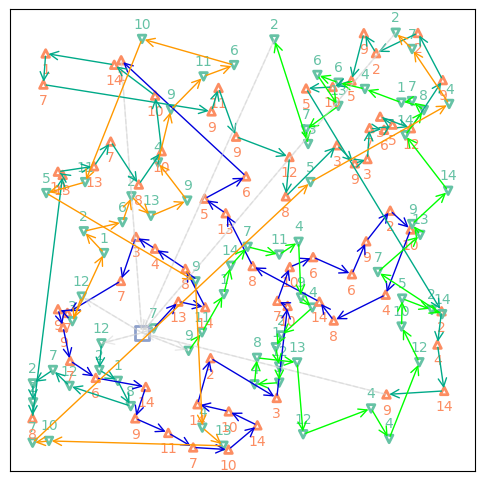

Cost:  17.063993453979492
Problem:  OVRPB


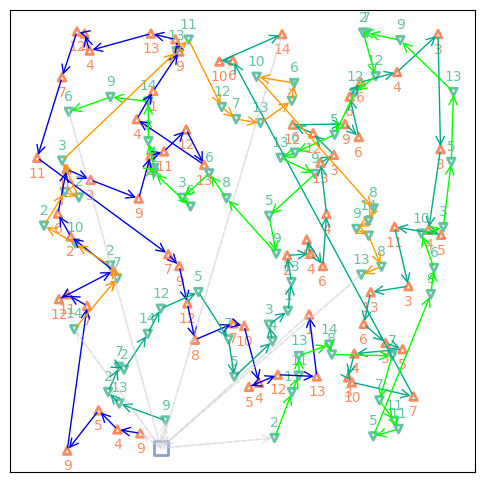

Cost:  14.846855163574219
Problem:  OVRPB


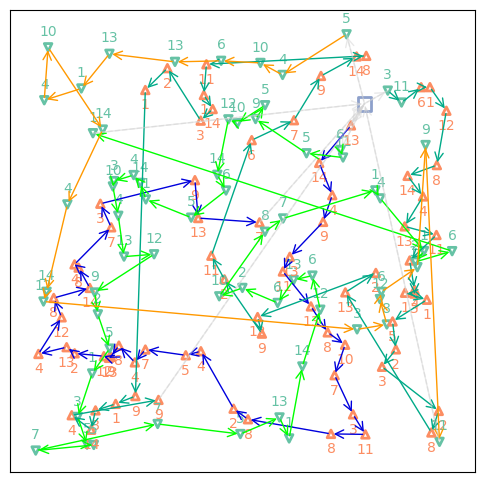

Cost:  16.50757598876953
Problem:  OVRPB


In [ ]:
td_data = env.generator(config['model_batch_size'])
variant_names = env.get_variant_names(td_data)

td = env.reset(td_data)

actions = rollout(env, td.clone(), greedy_policy)
rewards = env.get_reward(td, actions)

for idx in range(3):
    env.render(td[idx], actions[idx])
    print("Cost: ", - rewards[idx].item())
    print("Problem: ", variant_names[idx])

# **TRAIN**

In [ ]:
device_id = 0
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

env = MTVRPEnv(generator, check_solution=False)

In [ ]:
moe_kwargs = {"encoder": {"hidden_act": "ReLU", "num_experts": 4, "k": 2, "noisy_gating": True},
              "decoder": {"light_version": False, "num_experts": 4, "k": 2, "noisy_gating": True}}

model = MVMoE_POMO(
    env,
    moe_kwargs=moe_kwargs,
    batch_size=config['model_batch_size'],
    train_data_size=config['model_train_data_size'],
    val_batch_size=config['model_val_batch_size'],
    val_data_size=config['model_val_data_size'],
    optimizer=config['model_optimizer'],
    optimizer_kwargs=config['model_optimizer_kwargs'],
    lr_scheduler=config['model_lr_scheduler'],
    lr_scheduler_kwargs=config['model_lr_scheduler_kwargs']
    )

trainer = RL4COTrainer(
        max_epochs=config['trainer_max_epochs'],
        accelerator=config['trainer_accelerator'],
        devices=[device_id],
        logger=logger,
        callbacks=callbacks
    )

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU core

In [ ]:
trainer.fit(model)

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ MTVRPEnv              │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  3.7 M │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  3.6 M │ train │
│ 3  │ policy.encoder.init_embedding          │ MTVRPInitEmbedding    │  1.4 K │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  3.6 M │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │  149 K │ train │
│ 6  │ policy.decoder.context_embedding       │ MTVRPContext          │ 17.0 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ StaticEmbedding       │      0 │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttnMoE        │ 66.6 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ SharedBaseline        │      0 │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 3.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.7 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 300                                                                                         
Modules in eval mode: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# **SAVE MODEL**

In [ ]:
trainer.save_checkpoint(f"{config['experience']}.ckpt")

In [ ]:
print(f'model is:\n{model}','\n')
print('dir(model) is:')
for elem in dir(model):
  print(elem)
print('\n')
print(f'trainer is: {trainer}','\n')
print('dir(trainer) is:')
for elem in dir(trainer):
  print(elem)

print(trainer.model)

model is:
MVMoE_POMO(
  (env): MTVRPEnv()
  (policy): AttentionModelPolicy(
    (encoder): AttentionModelEncoder(
      (init_embedding): MTVRPInitEmbedding(
        (init_embed): Linear(in_features=7, out_features=128, bias=True)
        (init_embed_depot): Linear(in_features=2, out_features=128, bias=True)
      )
      (net): GraphAttentionNetwork(
        (layers): Sequential(
          (0): MultiHeadAttentionLayer(
            (0): SkipConnection(
              (module): MultiHeadAttention(
                (Wqkv): Linear(in_features=128, out_features=384, bias=True)
                (out_proj): Linear(in_features=128, out_features=128, bias=True)
              )
            )
            (1): Normalization(
              (normalizer): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            )
            (2): SkipConnection(
              (module): MoE(
                (experts): ModuleList(
                  (0-3): 4 x MLP(
                 

# **VISUALIZATIONS**

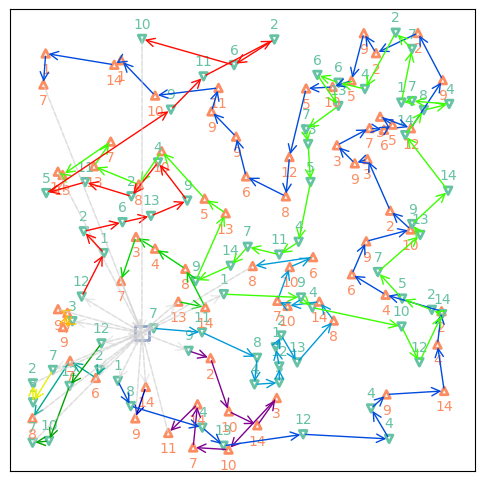

Cost:  14.108001708984375
Problem:  OVRPB


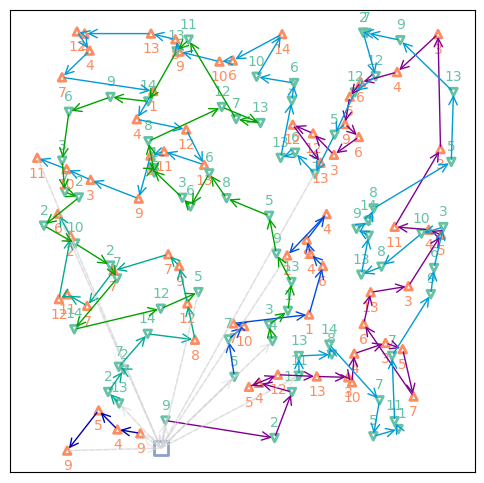

Cost:  13.584482192993164
Problem:  OVRPB


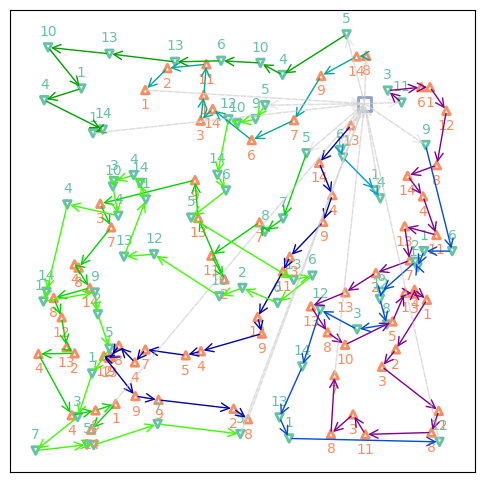

Cost:  13.181961059570312
Problem:  OVRPB


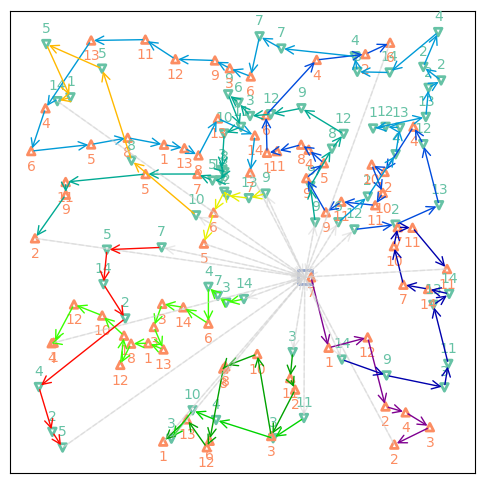

Cost:  13.160634994506836
Problem:  OVRPB


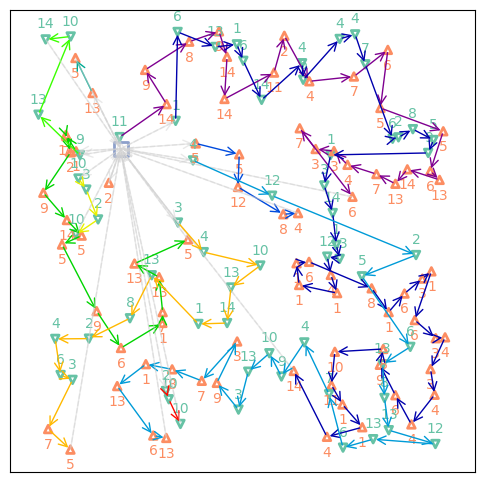

Cost:  13.941099166870117
Problem:  OVRPB


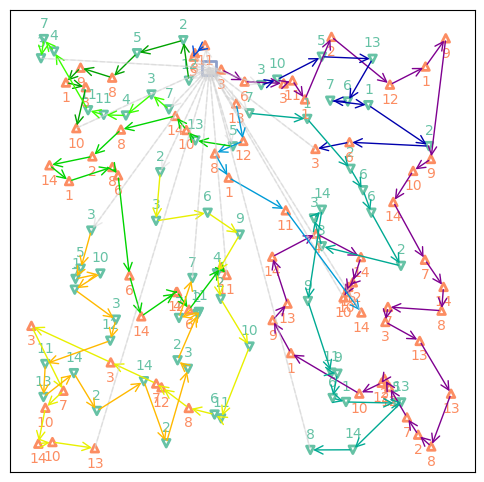

Cost:  13.896671295166016
Problem:  OVRPB


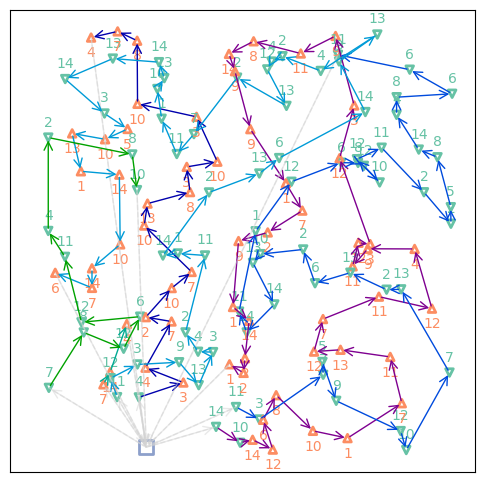

Cost:  14.66464900970459
Problem:  OVRPB


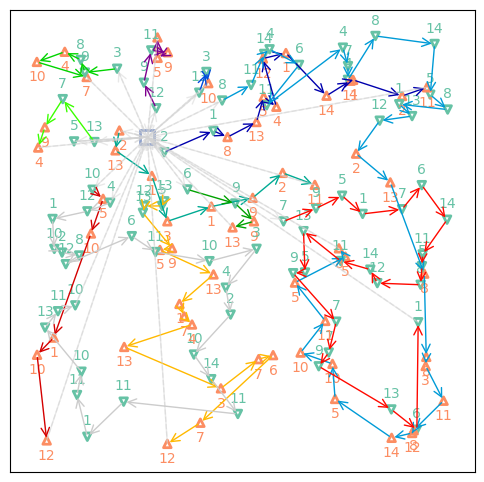

Cost:  13.810500144958496
Problem:  OVRPB


In [ ]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
# recorde-se que td = env.reset(td_data)
out = policy(td.to(device).clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_mvmoe = out['actions'].cpu().detach()
rewards_mvmoe = out['reward'].cpu().detach()

for idx in range(config['model_batch_size']):
    env.render(td[idx], actions_mvmoe[idx])
    print("Cost: ", -rewards_mvmoe[idx].item())
    print("Problem: ", variant_names[idx])

# **TEST**

By default, the dataset is generated or loaded by the environment.
You may load a dataset by setting test_file during the env config:
env = SDVRPEnv(...,test_file="path/to/test/file")

In [ ]:
model_name = "epoch_epoch=003.ckpt"
model_folder = "exp15_final_ovrpb_144pts_MVMoE_POMO_8BS_4epocas"

checkpoint_path = f"./lightning_logs/{model_folder}/checkpoints/{model_name}"

lit_model = MVMoE_POMO.load_from_checkpoint(checkpoint_path, load_baseline=False)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [ ]:
trainer.test(model)

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │        -14.359375         │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -14.359375}]

In [ ]:
#para continuar a testar esta questão, vamos fazer o upload do modelo:
checkpoint_path = "./exp9_cvrp_144pts_MVMoE_POMO_8BS_4epocas.ckpt"
lit_model = MVMoE_POMO.load_from_checkpoint(checkpoint_path, load_baseline=False)

batch_size=[3]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")

policy, env = lit_model.policy, lit_model.env
#policy = policy.to(device)

td = env.reset(batch_size=batch_size)
td = td.to(device)

td['num_locations'] = [[144],[144],[144]] #talvez seja preciso incluir esta linha de info para não erro mais à frente

In [ ]:
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([3, 145]), device=cuda:0, dtype=torch.bool, is_shared=True),
        capacity_original: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        current_node: Tensor(shape=torch.Size([3]), device=cuda:0, dtype=torch.int64, is_shared=True),
        current_route_length: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        current_time: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        demand_backhaul: Tensor(shape=torch.Size([3, 145]), device=cuda:0, dtype=torch.float32, is_shared=True),
        demand_linehaul: Tensor(shape=torch.Size([3, 145]), device=cuda:0, dtype=torch.float32, is_shared=True),
        distance_limit: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=Tru

# **GOOGLE OR TOOLS**

onde se resolve um problema recorrendo a um *solver*,

comparando-se os resultados e encontrando-se a
*optimamity gap*

In [ ]:
!python -m pip install ortools
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 22.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.2 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have proto

In [ ]:
import numpy as np

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [ ]:
# Create a random matrix
random_matrix = np.random.randint(1, 1001, size=(150, 150))

# Make the matrix symmetric
symmetric_matrix = np.triu(random_matrix) + np.triu(random_matrix, 1).T

# Set the diagonal to zero
np.fill_diagonal(symmetric_matrix, 0)

[[  0  20 886 ... 434 595 681]
 [ 20   0 115 ... 729 983 766]
 [886 115   0 ... 908 890 584]
 ...
 [434 729 908 ...   0 568  78]
 [595 983 890 ... 568   0 469]
 [681 766 584 ...  78 469   0]]


In [ ]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = symmetric_matrix
    data["num_vehicles"] = 15
    data["depot"] = 0
    return data

In [ ]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

NameError: name 'routing' is not defined

In [ ]:
dimension_name = "Distance"
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name,
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

Objective: 3513
Route for vehicle 0:
 0 -> 10 -> 0
Distance of the route: 44m

Route for vehicle 1:
 0 -> 0
Distance of the route: 0m

Route for vehicle 2:
 0 -> 0
Distance of the route: 0m

Route for vehicle 3:
 0 -> 0
Distance of the route: 0m

Route for vehicle 4:
 0 -> 0
Distance of the route: 0m

Route for vehicle 5:
 0 -> 0
Distance of the route: 0m

Route for vehicle 6:
 0 -> 0
Distance of the route: 0m

Route for vehicle 7:
 0 -> 0
Distance of the route: 0m

Route for vehicle 8:
 0 -> 0
Distance of the route: 0m

Route for vehicle 9:
 0 -> 0
Distance of the route: 0m

Route for vehicle 10:
 0 -> 0
Distance of the route: 0m

Route for vehicle 11:
 0 -> 0
Distance of the route: 0m

Route for vehicle 12:
 0 -> 0
Distance of the route: 0m

Route for vehicle 13:
 0 -> 0
Distance of the route: 0m

Route for vehicle 14:
 0 -> 119 -> 7 -> 30 -> 74 -> 57 -> 85 -> 149 -> 68 -> 90 -> 1 -> 26 -> 109 -> 50 -> 126 -> 143 -> 28 -> 40 -> 22 -> 73 -> 51 -> 104 -> 96 -> 25 -> 72 -> 2 -> 125 -> 6

In [ ]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")

In [ ]:
"""Simple Vehicles Routing Problem (VRP).

   This is a sample using the routing library python wrapper to solve a VRP
   problem.
   A description of the problem can be found here:
   http://en.wikipedia.org/wiki/Vehicle_routing_problem.

   Distances are in meters.
"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = symmetric_matrix
    data["num_vehicles"] = 15
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")



def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")


if __name__ == "__main__":
    main()

Objective: 67783
Route for vehicle 0:
 0 ->  38 ->  81 ->  147 ->  123 ->  63 ->  80 ->  134 ->  51 ->  2 ->  42 ->  145 ->  69 ->  95 ->  14 ->  74 ->  44 ->  55 ->  37 ->  119 ->  34 ->  114 -> 0
Distance of the route: 611m

Route for vehicle 1:
 0 ->  112 ->  143 ->  43 ->  118 ->  59 ->  7 ->  60 ->  98 ->  3 ->  104 ->  28 ->  31 ->  64 ->  126 ->  106 -> 0
Distance of the route: 515m

Route for vehicle 2:
 0 ->  30 ->  61 ->  88 ->  137 ->  45 ->  75 ->  130 ->  141 ->  92 ->  39 ->  121 ->  22 ->  90 ->  40 ->  78 ->  110 ->  115 ->  82 ->  1 -> 0
Distance of the route: 604m

Route for vehicle 3:
 0 ->  116 ->  68 ->  41 ->  15 ->  19 ->  56 ->  16 ->  62 ->  127 ->  6 ->  25 ->  132 ->  109 ->  97 ->  36 -> 0
Distance of the route: 603m

Route for vehicle 4:
 0 ->  23 ->  33 ->  26 ->  111 ->  77 ->  138 ->  8 ->  146 ->  57 ->  108 ->  139 ->  79 ->  89 ->  94 ->  10 -> 0
Distance of the route: 594m

Route for vehicle 5:
 0 ->  144 ->  103 ->  52 ->  136 ->  67 ->  117 ->  32 